In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
from sqlalchemy import inspect
inspector = inspect (engine)

In [11]:
inspector.get_columns('measurement')


[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23',)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-27'),
  Text(0.0, 0, '2016-08-23'),
  Text(500.0, 0, '2016-11-09'),
  Text(1000.0, 0, '2017-01-28'),
  Text(1500.0, 0, '2017-04-18'),
  Text(2000.0, 0, '2017-07-10'),
  Text(2500.0, 0, '')])

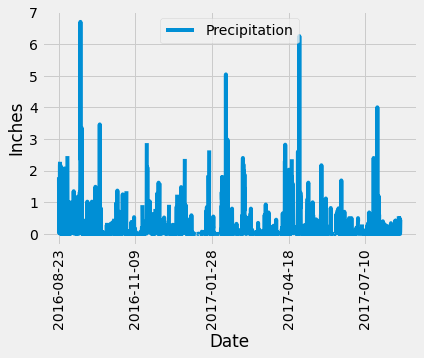

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print(query_date)

# Perform a query to retrieve the data and precipitation scores
precipData = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()
#print(precipData)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipDF= pd.DataFrame(precipData, columns=['Date','Precipitation'])
precipDF.set_index("Date", inplace=True)

# Sort the dataframe by date
precipGraphDF = precipDF.sort_values("Date", ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data
precipGraphDF.plot()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipDF.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
inspector.get_columns('station')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [16]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station).count()
print(total_stations)

9


In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print("Active Stations and counts:")
print("---------------------------")
active_stations
    

Active Stations and counts:
---------------------------


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
   
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_stations[0][0]).all()
print(f" Most active station: {active_stations[0][0]}")
print("-------------------------------------")
print(f" Lowest temperature: {temperature_stats[0][0]}")
print(f" Highest temperature: {temperature_stats[0][1]}")
print(f" Average temperature: {temperature_stats[0][2]}")


 Most active station: USC00519281
-------------------------------------
 Lowest temperature: 54.0
 Highest temperature: 85.0
 Average temperature: 71.66378066378067


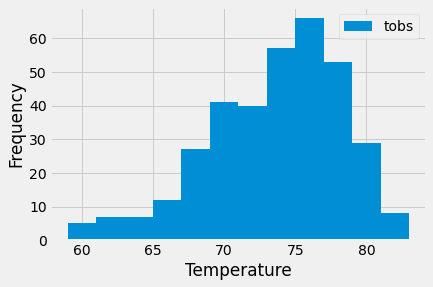

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
    
activeStationTemps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == active_stations[0][0]).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
activeStationTemps_df= pd.DataFrame(activeStationTemps, columns=['Date','tobs'])
activeStationTemps_df.set_index("Date", drop=True)

#Plot the results as a histogram with bins=12
plt.hist(activeStationTemps_df['tobs'],12, label= "tobs")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()

# Close Session

In [31]:
session.close()
